## Overview

The assessment is based on a Zindi competition. Zindi is an African platform for data science problems with a social / sustainability angle.

The objective of this competition is to create a machine learning model to help SuperLender identify customers that have a high risk to fail to meet the legal loan obligations.

The data has been provided in CSV format and already split into a Training set and Test set. 
We are working with 3 diff testing and training sets (Demographics, pref, prevloans). Zindi require the follwing 1) willingness to pay and 2) ability to pay.

The following datasets are provided :

Demographic data (traindemographics.csv) : User information 

Performance data (trainperf.csv) : This is the repeat loan that the customer has taken for which we need to predict the performance of. Basically, we need to predict whether this loan would default given all previous loans and demographics of a customer.

Previous loans data (trainprevloans.csv) : This dataset contains all previous loans that the customer had prior to the loan above that we want to predict the performance of. Each loan will have a different systemloanid, but the same customerid for each customer.

We have a sample submission that has 2 outcomes- good (1) or bad (0).

My initial thoughs on the project is the following:

1. Explore the data
2. Merging the data
3. Adding the target colomn
4. Working with missing values
5. Feature Engineering
6. Feature Selection
7. Modeling
8. Evaluating 
9. Exporting


### Importing Libraries

In [764]:
import pandas as pd                             #dataframe manipulation
import numpy as np                              #numerical python
import seaborn as sns                           #visualization
import matplotlib as mpl                        #plotting
import matplotlib.pyplot as plt                 #plotting
import itertools
import datetime as dt                           #convert date formats
from scipy import stats                         #statistical analysis


from IPython.display import display             # Allows the use of display() for DataFrames

### Importing Data

In [765]:
#importing all training data from CSV

df_train_demo = pd.read_csv('traindemographics.csv',parse_dates=['birthdate'])
df_train_pref = pd.read_csv('trainperf.csv',parse_dates=['approveddate','creationdate'])
df_train_prev = pd.read_csv('trainprevloans.csv',parse_dates=['approveddate','creationdate','closeddate','firstduedate','firstrepaiddate'])
df_test_demo = pd.read_csv('testdemographics.csv',parse_dates=['birthdate'])
df_test_pref = pd.read_csv('testperf.csv',parse_dates=['approveddate','creationdate'])
df_test_prev = pd.read_csv('testprevloans.csv',parse_dates=['approveddate','creationdate','closeddate','firstduedate','firstrepaiddate'])

#### 1. Initial Data Check - Using the .head function we can have a look at the first few rows of each dataset (Only checking the train set)

In [766]:
df_train_demo.head()

,customerid,birthdate,bank_account_type,longitude_gps,latitude_gps,bank_name_clients,bank_branch_clients,employment_status_clients,level_of_education_clients
0,8a858e135cb22031015cbafc76964ebd,1973-10-10,Savings,3.319219,6.528604,GT Bank,NaN,NaN,NaN
1,8a858e275c7ea5ec015c82482d7c3996,1986-01-21,Savings,3.325598,7.119403,Sterling Bank,NaN,Permanent,NaN
2,8a858e5b5bd99460015bdc95cd485634,1987-04-01,Savings,5.746100,5.563174,Fidelity Bank,NaN,NaN,NaN
3,8a858efd5ca70688015cabd1f1e94b55,1991-07-19,Savings,3.362850,6.642485,GT Bank,NaN,Permanent,NaN
4,8a858e785acd3412015acd48f4920d04,1982-11-22,Savings,8.455332,11.971410,GT Bank,NaN,Permanent,NaN


In [767]:
df_train_pref.head()

,customerid,systemloanid,loannumber,approveddate,creationdate,loanamount,totaldue,termdays,referredby,good_bad_flag
0,8a2a81a74ce8c05d014cfb32a0da1049,301994762,12,2017-07-25 08:22:56,2017-07-25 07:22:47,30000.0,34500.0,30,NaN,Good
1,8a85886e54beabf90154c0a29ae757c0,301965204,2,2017-07-05 17:04:41,2017-07-05 16:04:18,15000.0,17250.0,30,NaN,Good
2,8a8588f35438fe12015444567666018e,301966580,7,2017-07-06 14:52:57,2017-07-06 13:52:51,20000.0,22250.0,15,NaN,Good
3,8a85890754145ace015429211b513e16,301999343,3,2017-07-27 19:00:41,2017-07-27 18:00:35,10000.0,11500.0,15,NaN,Good
4,8a858970548359cc0154883481981866,301962360,9,2017-07-03 23:42:45,2017-07-03 22:42:39,40000.0,44000.0,30,NaN,Good


In [768]:
df_train_prev.head()

,customerid,systemloanid,loannumber,approveddate,creationdate,loanamount,totaldue,termdays,closeddate,referredby,firstduedate,firstrepaiddate
0,8a2a81a74ce8c05d014cfb32a0da1049,301682320,2,2016-08-15 18:22:40,2016-08-15 17:22:32,10000.0,13000.0,30,2016-09-01 16:06:48,NaN,2016-09-14,2016-09-01 15:51:43
1,8a2a81a74ce8c05d014cfb32a0da1049,301883808,9,2017-04-28 18:39:07,2017-04-28 17:38:53,10000.0,13000.0,30,2017-05-28 14:44:49,NaN,2017-05-30,2017-05-26 00:00:00
2,8a2a81a74ce8c05d014cfb32a0da1049,301831714,8,2017-03-05 10:56:25,2017-03-05 09:56:19,20000.0,23800.0,30,2017-04-26 22:18:56,NaN,2017-04-04,2017-04-26 22:03:47
3,8a8588f35438fe12015444567666018e,301861541,5,2017-04-09 18:25:55,2017-04-09 17:25:42,10000.0,11500.0,15,2017-04-24 01:35:52,NaN,2017-04-24,2017-04-24 00:48:43
4,8a85890754145ace015429211b513e16,301941754,2,2017-06-17 09:29:57,2017-06-17 08:29:50,10000.0,11500.0,15,2017-07-14 21:18:43,NaN,2017-07-03,2017-07-14 21:08:35


#### 2. Merging the dataset

Based of our findings and the initial dataset we can confirm that the data needs to be merged. We will merge all data and tag the data in order to specify whether its from the train or test set

In [769]:
df_train_demo['set'] = 'train'
df_test_demo['set'] = 'test'
df_train_pref['set'] = 'train'
df_test_pref['set'] = 'test'
df_train_prev['set'] = 'train'
df_test_prev['set'] = 'test'

In [770]:
df_demo=pd.concat([df_train_demo,df_test_demo])
df_perf=pd.concat([df_train_pref,df_test_pref])
df_prev=pd.concat([df_train_prev,df_test_prev])

In [771]:
df_demo.head()

,customerid,birthdate,bank_account_type,longitude_gps,latitude_gps,bank_name_clients,bank_branch_clients,employment_status_clients,level_of_education_clients,set
0,8a858e135cb22031015cbafc76964ebd,1973-10-10,Savings,3.319219,6.528604,GT Bank,NaN,NaN,NaN,train
1,8a858e275c7ea5ec015c82482d7c3996,1986-01-21,Savings,3.325598,7.119403,Sterling Bank,NaN,Permanent,NaN,train
2,8a858e5b5bd99460015bdc95cd485634,1987-04-01,Savings,5.746100,5.563174,Fidelity Bank,NaN,NaN,NaN,train
3,8a858efd5ca70688015cabd1f1e94b55,1991-07-19,Savings,3.362850,6.642485,GT Bank,NaN,Permanent,NaN,train
4,8a858e785acd3412015acd48f4920d04,1982-11-22,Savings,8.455332,11.971410,GT Bank,NaN,Permanent,NaN,train


#### 3. Adding the target colomns

In [772]:
goodbad={'Good':1,'Bad':0}
df_perf.good_bad_flag=df_perf.good_bad_flag.map(goodbad)

In [773]:
df_perf.head()

,customerid,systemloanid,loannumber,approveddate,creationdate,loanamount,totaldue,termdays,referredby,good_bad_flag,set
0,8a2a81a74ce8c05d014cfb32a0da1049,301994762,12,2017-07-25 08:22:56,2017-07-25 07:22:47,30000.0,34500.0,30,NaN,1.0,train
1,8a85886e54beabf90154c0a29ae757c0,301965204,2,2017-07-05 17:04:41,2017-07-05 16:04:18,15000.0,17250.0,30,NaN,1.0,train
2,8a8588f35438fe12015444567666018e,301966580,7,2017-07-06 14:52:57,2017-07-06 13:52:51,20000.0,22250.0,15,NaN,1.0,train
3,8a85890754145ace015429211b513e16,301999343,3,2017-07-27 19:00:41,2017-07-27 18:00:35,10000.0,11500.0,15,NaN,1.0,train
4,8a858970548359cc0154883481981866,301962360,9,2017-07-03 23:42:45,2017-07-03 22:42:39,40000.0,44000.0,30,NaN,1.0,train


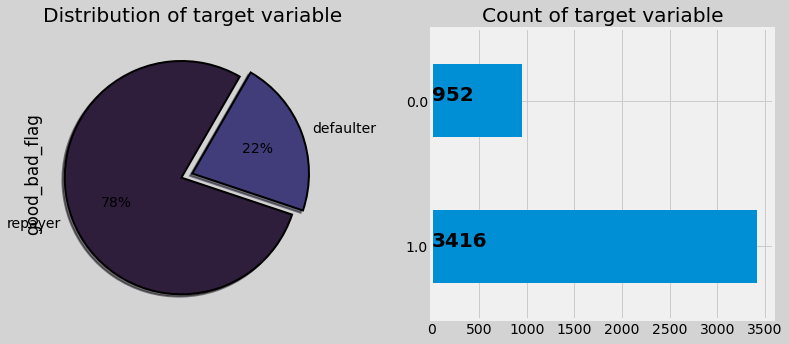

In [774]:
# Distribution of the target variable
fig = plt.figure(figsize=(12, 5))
plt.subplot(121)
df_perf[df_perf['set'] == "train"]["good_bad_flag"].value_counts().plot.pie(autopct = "%1.0f%%",colors = sns.color_palette("mako"),
                                                                             startangle = 60,
                                            labels=["repayer","defaulter"],wedgeprops={"linewidth":2,"edgecolor":"k"},explode=[.1,0],shadow =True)
plt.title("Distribution of target variable")

plt.subplot(122)
ax = df_perf[df_perf['set'] == "train"]["good_bad_flag"].value_counts().plot(kind="barh")

for i,j in enumerate(df_perf[df_perf['set'] == "train"]["good_bad_flag"].value_counts().values):
    ax.text(.7,i,j,weight = "bold",fontsize=20)

plt.title("Count of target variable")
#ax.set_facecolor("k")
fig.set_facecolor("lightgrey")
plt.show()

#### 4. Working with missing values

Percentage of Missing values in other data sets

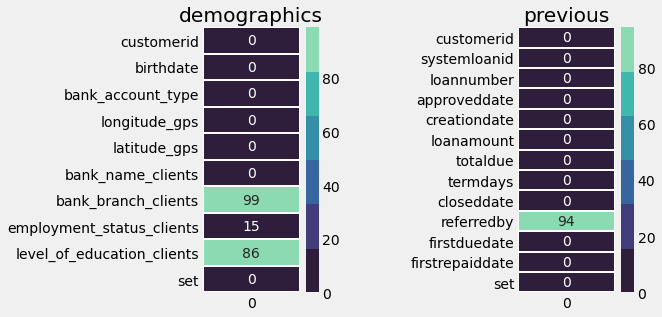

In [775]:
plt.figure(figsize=(12,10))

plt.subplot(231)
sns.heatmap(pd.DataFrame(df_demo.isnull().sum()/df_demo.shape[0]*100),annot=True,
            cmap=sns.color_palette("mako"),linewidth=1,linecolor="white")
plt.title("demographics")

plt.subplot(232)
sns.heatmap(pd.DataFrame(df_prev.isnull().sum()/df_prev.shape[0]*100),annot=True,
            cmap=sns.color_palette("mako"),linewidth=1,linecolor="white")
plt.title("previous")

plt.subplots_adjust(wspace = 1.6)

#### 4.1 Feature Engineering (Demographics)

In [776]:
df_demo.head()

,customerid,birthdate,bank_account_type,longitude_gps,latitude_gps,bank_name_clients,bank_branch_clients,employment_status_clients,level_of_education_clients,set
0,8a858e135cb22031015cbafc76964ebd,1973-10-10,Savings,3.319219,6.528604,GT Bank,NaN,NaN,NaN,train
1,8a858e275c7ea5ec015c82482d7c3996,1986-01-21,Savings,3.325598,7.119403,Sterling Bank,NaN,Permanent,NaN,train
2,8a858e5b5bd99460015bdc95cd485634,1987-04-01,Savings,5.746100,5.563174,Fidelity Bank,NaN,NaN,NaN,train
3,8a858efd5ca70688015cabd1f1e94b55,1991-07-19,Savings,3.362850,6.642485,GT Bank,NaN,Permanent,NaN,train
4,8a858e785acd3412015acd48f4920d04,1982-11-22,Savings,8.455332,11.971410,GT Bank,NaN,Permanent,NaN,train


##### Dropping duplicates

In [777]:
df_demo.drop_duplicates(subset=df_demo.columns,keep='last', inplace=True)

##### Creating Age category

In [778]:
df_demo['Age_x']=2020-df_demo.birthdate.dt.year #2020 being the current year

In [779]:
df_demo.head(3)

,customerid,birthdate,bank_account_type,longitude_gps,latitude_gps,bank_name_clients,bank_branch_clients,employment_status_clients,level_of_education_clients,set,Age_x
0,8a858e135cb22031015cbafc76964ebd,1973-10-10,Savings,3.319219,6.528604,GT Bank,NaN,NaN,NaN,train,47
1,8a858e275c7ea5ec015c82482d7c3996,1986-01-21,Savings,3.325598,7.119403,Sterling Bank,NaN,Permanent,NaN,train,34
2,8a858e5b5bd99460015bdc95cd485634,1987-04-01,Savings,5.746100,5.563174,Fidelity Bank,NaN,NaN,NaN,train,33


In [780]:
df_demo['Age_y'] = df_demo['Age_x']

In [781]:
df_demo.head(3)

,customerid,birthdate,bank_account_type,longitude_gps,latitude_gps,bank_name_clients,bank_branch_clients,employment_status_clients,level_of_education_clients,set,Age_x,Age_y
0,8a858e135cb22031015cbafc76964ebd,1973-10-10,Savings,3.319219,6.528604,GT Bank,NaN,NaN,NaN,train,47,47
1,8a858e275c7ea5ec015c82482d7c3996,1986-01-21,Savings,3.325598,7.119403,Sterling Bank,NaN,Permanent,NaN,train,34,34
2,8a858e5b5bd99460015bdc95cd485634,1987-04-01,Savings,5.746100,5.563174,Fidelity Bank,NaN,NaN,NaN,train,33,33


In [782]:
df_demo.Age_x=pd.cut(df_demo.Age_x,[0,13,31,51,100],labels=['ChildAge','YoungAge','MiddleAge','SeniorAge'])

In [783]:
df_demo.head(3)

,customerid,birthdate,bank_account_type,longitude_gps,latitude_gps,bank_name_clients,bank_branch_clients,employment_status_clients,level_of_education_clients,set,Age_x,Age_y
0,8a858e135cb22031015cbafc76964ebd,1973-10-10,Savings,3.319219,6.528604,GT Bank,NaN,NaN,NaN,train,MiddleAge,47
1,8a858e275c7ea5ec015c82482d7c3996,1986-01-21,Savings,3.325598,7.119403,Sterling Bank,NaN,Permanent,NaN,train,MiddleAge,34
2,8a858e5b5bd99460015bdc95cd485634,1987-04-01,Savings,5.746100,5.563174,Fidelity Bank,NaN,NaN,NaN,train,MiddleAge,33


##### Type of primary bank account

In [784]:
df_demo["bank_account_type"].value_counts()

Savings    4570
Other      1168
Current      80
Name: bank_account_type, dtype: int64

In [785]:
df_demo["bank_account_type"] = df_demo["bank_account_type"].replace("Current", "Other")

In [786]:
df_demo["bank_account_type"].value_counts()

Savings    4570
Other      1248
Name: bank_account_type, dtype: int64

In [787]:
pd.crosstab(df_demo.employment_status_clients,df_demo.bank_account_type,margins=True).style.background_gradient(cmap='summer_r')

bank_account_type,Other,Savings,All
employment_status_clients,,,
Contract,1,1,2
Permanent,813,3392,4205
Retired,2,6,8
Self-Employed,322,148,470
Student,73,116,189
Unemployed,25,54,79
All,1236,3717,4953


In [788]:
df_demo[df_demo["Age_y"].isnull()]["bank_name_clients"].unique()

array([], dtype=object)

In [789]:
df_demo.head()

,customerid,birthdate,bank_account_type,longitude_gps,latitude_gps,bank_name_clients,bank_branch_clients,employment_status_clients,level_of_education_clients,set,Age_x,Age_y
0,8a858e135cb22031015cbafc76964ebd,1973-10-10,Savings,3.319219,6.528604,GT Bank,NaN,NaN,NaN,train,MiddleAge,47
1,8a858e275c7ea5ec015c82482d7c3996,1986-01-21,Savings,3.325598,7.119403,Sterling Bank,NaN,Permanent,NaN,train,MiddleAge,34
2,8a858e5b5bd99460015bdc95cd485634,1987-04-01,Savings,5.746100,5.563174,Fidelity Bank,NaN,NaN,NaN,train,MiddleAge,33
3,8a858efd5ca70688015cabd1f1e94b55,1991-07-19,Savings,3.362850,6.642485,GT Bank,NaN,Permanent,NaN,train,YoungAge,29
4,8a858e785acd3412015acd48f4920d04,1982-11-22,Savings,8.455332,11.971410,GT Bank,NaN,Permanent,NaN,train,MiddleAge,38


In [790]:
df_demo.drop(columns=['bank_name_clients','bank_branch_clients','birthdate'],axis=1,inplace=True)

In [791]:
df_demo.head()

,customerid,bank_account_type,longitude_gps,latitude_gps,employment_status_clients,level_of_education_clients,set,Age_x,Age_y
0,8a858e135cb22031015cbafc76964ebd,Savings,3.319219,6.528604,NaN,NaN,train,MiddleAge,47
1,8a858e275c7ea5ec015c82482d7c3996,Savings,3.325598,7.119403,Permanent,NaN,train,MiddleAge,34
2,8a858e5b5bd99460015bdc95cd485634,Savings,5.746100,5.563174,NaN,NaN,train,MiddleAge,33
3,8a858efd5ca70688015cabd1f1e94b55,Savings,3.362850,6.642485,Permanent,NaN,train,YoungAge,29
4,8a858e785acd3412015acd48f4920d04,Savings,8.455332,11.971410,Permanent,NaN,train,MiddleAge,38


##### Education

In [792]:
df_demo["level_of_education_clients"].value_counts()

Graduate         576
Secondary        118
Post-Graduate     90
Primary           11
Name: level_of_education_clients, dtype: int64

#### 4.2 Feature Engineering (Previous)

In [793]:
df_prev.head(3)

,customerid,systemloanid,loannumber,approveddate,creationdate,loanamount,totaldue,termdays,closeddate,referredby,firstduedate,firstrepaiddate,set
0,8a2a81a74ce8c05d014cfb32a0da1049,301682320,2,2016-08-15 18:22:40,2016-08-15 17:22:32,10000.0,13000.0,30,2016-09-01 16:06:48,NaN,2016-09-14,2016-09-01 15:51:43,train
1,8a2a81a74ce8c05d014cfb32a0da1049,301883808,9,2017-04-28 18:39:07,2017-04-28 17:38:53,10000.0,13000.0,30,2017-05-28 14:44:49,NaN,2017-05-30,2017-05-26 00:00:00,train
2,8a2a81a74ce8c05d014cfb32a0da1049,301831714,8,2017-03-05 10:56:25,2017-03-05 09:56:19,20000.0,23800.0,30,2017-04-26 22:18:56,NaN,2017-04-04,2017-04-26 22:03:47,train


##### Calculating profit

In [794]:
df_prev['profit']=df_prev['totaldue']-df_prev['loanamount']

##### Calculating Return Days

In [795]:
df_prev['return_days']=df_prev.closeddate-df_prev.approveddate
df_prev['return_days']=df_prev['return_days'].apply(lambda x:int(str(x)[:2]))

##### Days Left

In [796]:
df_prev['days_left']=df_prev.termdays-df_prev.return_days

##### Feature Extraction

In [797]:
#Totalprofit
Totalprofit=df_prev.pivot_table(values='profit',index='customerid',aggfunc=sum)
Totalprofit.rename(columns={'profit':'Totalprofit'},inplace=True)

#Avgprofit
Avgprofit=df_prev.pivot_table(values='profit',index='customerid',aggfunc=np.mean)
Avgprofit.rename(columns={'profit':'Avgprofit'},inplace=True)

#Avgloanamount
Avgloanamount=df_prev.pivot_table(values='loanamount',index='customerid',aggfunc=np.mean)
Avgloanamount.rename(columns={'loanamount':'Avgloanamount'},inplace=True)

#Avgtermdays
Avgtermdays=df_prev.pivot_table(values='termdays',index='customerid',aggfunc=np.mean)
Avgtermdays.rename(columns={'termdays':'Avgtermdays'},inplace=True)

#Earlypayment
Earlypayment=df_prev.pivot_table(values='days_left',index='customerid',aggfunc=lambda x:(x>=0).sum())
Earlypayment.rename(columns={'days_left':'Earlypayment'},inplace=True)

#Avgdaysleft
Avgdaysleft=df_prev.pivot_table(values='days_left',index='customerid',aggfunc=np.mean)
Avgdaysleft.rename(columns={'days_left':'Avgdaysleft'},inplace=True)

In [798]:
data=[Totalprofit,Avgprofit,Avgloanamount,Avgtermdays,Avgdaysleft,Earlypayment]

In [799]:
data=data[0].join(data[1:])

In [800]:
data.head(3)

,Totalprofit,Avgprofit,Avgloanamount,Avgtermdays,Avgdaysleft,Earlypayment
customerid,,,,,,
8a1088a0484472eb01484669e3ce4e0b,1500.0,1500.000000,10000.000000,15.000000,-7.00,0
8a1a1e7e4f707f8b014f797718316cad,19500.0,4875.000000,17500.000000,37.500000,6.25,3
8a1a32fc49b632520149c3b8fdf85139,16500.0,2357.142857,12857.142857,19.285714,1.00,6


#### 4.3 Feature Engineering (Performance)

In [801]:
df_perf.head(3)

,customerid,systemloanid,loannumber,approveddate,creationdate,loanamount,totaldue,termdays,referredby,good_bad_flag,set
0,8a2a81a74ce8c05d014cfb32a0da1049,301994762,12,2017-07-25 08:22:56,2017-07-25 07:22:47,30000.0,34500.0,30,NaN,1.0,train
1,8a85886e54beabf90154c0a29ae757c0,301965204,2,2017-07-05 17:04:41,2017-07-05 16:04:18,15000.0,17250.0,30,NaN,1.0,train
2,8a8588f35438fe12015444567666018e,301966580,7,2017-07-06 14:52:57,2017-07-06 13:52:51,20000.0,22250.0,15,NaN,1.0,train


##### Calculating profit

In [802]:
df_perf['new_profit']=df_perf['totaldue']-df_perf['loanamount']

##### Dropping columns not needed

In [803]:
df_perf.drop(columns=['systemloanid','referredby','creationdate','approveddate','totaldue'],inplace=True)

#### Merge the datasets¶

In [804]:
#merge data which has attributes from previous loans to performance data
data=pd.merge(data.reset_index(),df_perf,how='outer',on='customerid')

In [805]:
data.head(3)

,customerid,Totalprofit,Avgprofit,Avgloanamount,Avgtermdays,Avgdaysleft,Earlypayment,loannumber,loanamount,termdays,good_bad_flag,set,new_profit
0,8a1088a0484472eb01484669e3ce4e0b,1500.0,1500.000000,10000.000000,15.000000,-7.00,0.0,2,10000.0,15,0.0,train,1500.0
1,8a1a1e7e4f707f8b014f797718316cad,19500.0,4875.000000,17500.000000,37.500000,6.25,3.0,5,30000.0,60,1.0,train,9000.0
2,8a1a32fc49b632520149c3b8fdf85139,16500.0,2357.142857,12857.142857,19.285714,1.00,6.0,8,20000.0,30,1.0,train,4500.0


In [806]:
data['loanamountdeviation']=data.Avgloanamount-data.loanamount
data['profitdeviation']=data.Avgprofit-data.new_profit
data['termdaysdeviation']=data.Avgtermdays-data.termdays

In [807]:
data.head(3)

,customerid,Totalprofit,Avgprofit,Avgloanamount,Avgtermdays,Avgdaysleft,Earlypayment,loannumber,loanamount,termdays,good_bad_flag,set,new_profit,loanamountdeviation,profitdeviation,termdaysdeviation
0,8a1088a0484472eb01484669e3ce4e0b,1500.0,1500.000000,10000.000000,15.000000,-7.00,0.0,2,10000.0,15,0.0,train,1500.0,0.000000,0.000000,0.000000
1,8a1a1e7e4f707f8b014f797718316cad,19500.0,4875.000000,17500.000000,37.500000,6.25,3.0,5,30000.0,60,1.0,train,9000.0,-12500.000000,-4125.000000,-22.500000
2,8a1a32fc49b632520149c3b8fdf85139,16500.0,2357.142857,12857.142857,19.285714,1.00,6.0,8,20000.0,30,1.0,train,4500.0,-7142.857143,-2142.857143,-10.714286


In [808]:
#merge data which has attributes from previous & performance loans to demographics data
data=pd.merge(data,df_demo,on='customerid',how='inner')

In [809]:
data.tail(3)

,customerid,Totalprofit,Avgprofit,Avgloanamount,Avgtermdays,Avgdaysleft,Earlypayment,loannumber,loanamount,termdays,...,profitdeviation,termdaysdeviation,bank_account_type,longitude_gps,latitude_gps,employment_status_clients,level_of_education_clients,set_y,Age_x,Age_y
5815,8a858e9f59d692440159da2c60b42106,NaN,NaN,NaN,NaN,NaN,NaN,2,20000.0,30,...,NaN,NaN,Savings,3.362373,6.642125,Permanent,Graduate,train,MiddleAge,35
5816,8a858f0d58a18ebc0158a9bf124b5a30,NaN,NaN,NaN,NaN,NaN,NaN,2,10000.0,15,...,NaN,NaN,Savings,3.309237,6.644254,Permanent,Graduate,train,YoungAge,29
5817,8a85890253e2f1180153eae33e5e6bc3,NaN,NaN,NaN,NaN,NaN,NaN,3,20000.0,30,...,NaN,NaN,Savings,3.373518,6.643441,Permanent,Graduate,train,MiddleAge,32


In [810]:
data.drop(columns=['set_x','set_y'],inplace=True)

In [811]:
data.shape

(5818, 22)

In [812]:
cols=[x for x in data.columns if x not in ['longitude_gps','latitude_gps']]
data=data[cols]

In [813]:
#export the data
data.to_csv('feature_matrix.csv', index=False)

### 5. Feature Selection

In [814]:
#calculate corelations
correlation =  data.corr()
correlation.to_csv('correlations_spec.csv')

In [815]:
correlations = pd.read_csv('correlations_spec.csv', index_col =0)
correlations.index.name = 'Variable'
correlations.head()

,Totalprofit,Avgprofit,Avgloanamount,Avgtermdays,Avgdaysleft,Earlypayment,loannumber,loanamount,termdays,good_bad_flag,new_profit,loanamountdeviation,profitdeviation,termdaysdeviation,Age_y
Variable,,,,,,,,,,,,,,,
Totalprofit,1.000000,0.656252,0.918545,0.428243,0.183404,0.902447,0.939435,0.859603,0.525033,0.089024,0.531113,-0.706319,-0.240100,-0.315246,-0.014213
Avgprofit,0.656252,1.000000,0.612499,0.927718,0.215257,0.467600,0.461867,0.544195,0.601286,0.051034,0.551618,-0.425418,-0.057425,-0.052901,0.028072
Avgloanamount,0.918545,0.612499,1.000000,0.332187,0.213481,0.860269,0.853561,0.889530,0.476376,0.104491,0.501083,-0.696206,-0.230532,-0.325750,-0.003509
Avgtermdays,0.428243,0.927718,0.332187,1.000000,0.188150,0.231985,0.223934,0.291613,0.529879,0.015887,0.408751,-0.225178,0.070003,0.081948,0.022467
Avgdaysleft,0.183404,0.215257,0.213481,0.188150,1.000000,0.286770,0.119987,0.234726,0.196652,0.238330,0.169256,-0.219060,-0.072825,-0.098522,0.018240


In [816]:
#correlation with target
correlations_target = correlations.sort_values('good_bad_flag')['good_bad_flag']
# Most negative correlations
correlations_target.head(5)

Variable
loanamountdeviation   -0.108633
profitdeviation       -0.010721
termdaysdeviation      0.003311
termdays               0.005160
Avgtermdays            0.015887
Name: good_bad_flag, dtype: float64

In [817]:
# Most positive correlations
correlations_target.dropna().tail(5)

Variable
Avgloanamount    0.104491
loanamount       0.115267
Earlypayment     0.146263
Avgdaysleft      0.238330
good_bad_flag    1.000000
Name: good_bad_flag, dtype: float64

#### Visualize Distribution of Correlated Variables

In [818]:
features_sample = pd.read_csv('feature_matrix.csv')
features_sample['good_bad_flag'] = features_sample['good_bad_flag'].fillna(-1).astype(int)
features_sample.head(3)

,customerid,Totalprofit,Avgprofit,Avgloanamount,Avgtermdays,Avgdaysleft,Earlypayment,loannumber,loanamount,termdays,good_bad_flag,new_profit,loanamountdeviation,profitdeviation,termdaysdeviation,bank_account_type,employment_status_clients,level_of_education_clients,Age_x,Age_y
0,8a1088a0484472eb01484669e3ce4e0b,1500.0,1500.000000,10000.000000,15.000000,-7.00,0.0,2,10000.0,15,0,1500.0,0.000000,0.000000,0.000000,Savings,Permanent,Primary,YoungAge,31
1,8a1a1e7e4f707f8b014f797718316cad,19500.0,4875.000000,17500.000000,37.500000,6.25,3.0,5,30000.0,60,1,9000.0,-12500.000000,-4125.000000,-22.500000,Other,Permanent,Graduate,MiddleAge,41
2,8a1a32fc49b632520149c3b8fdf85139,16500.0,2357.142857,12857.142857,19.285714,1.00,6.0,8,20000.0,30,1,4500.0,-7142.857143,-2142.857143,-10.714286,Savings,Permanent,Graduate,MiddleAge,41


In [819]:
 def kde_target_plot(df, feature):
    """Kernel density estimate plot of a feature colored
    by value of the target."""
    
    # Need to reset index for loc to workBU
    df = df.reset_index()
    plt.figure(figsize = (10, 6))
    plt.style.use('fivethirtyeight')
    
    # plot repaid loans
    sns.kdeplot(df.loc[df['good_bad_flag'] == 0, feature], label = 'target == 0')
    # plot loans that were not repaid
    sns.kdeplot(df.loc[df['good_bad_flag'] == 1, feature], label = 'target == 1')
    
    # Label the plots
    plt.title('Distribution of Feature by Target Value')
    plt.xlabel('%s' % feature); 
    plt.ylabel('Density');
    plt.show()

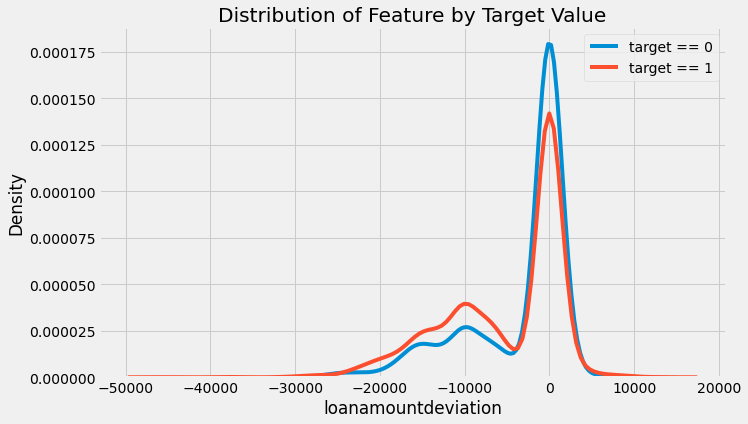

In [430]:
kde_target_plot(features_sample, feature = 'loanamountdeviation')

In [820]:
threshold = 0.9

correlated_pairs = {}

# Iterate through the columns
for col in correlations:
    # Find correlations above the threshold
    above_threshold_vars = [x for x in list(correlations.index[correlations[col] > threshold]) if x != col]
    correlated_pairs[col] = above_threshold_vars

In [821]:
correlated_pairs['Avgloanamount']

['Totalprofit']

In [822]:
correlations['Avgloanamount'].sort_values(ascending=False).head()

Variable
Avgloanamount    1.000000
Totalprofit      0.918545
loanamount       0.889530
Earlypayment     0.860269
loannumber       0.853561
Name: Avgloanamount, dtype: float64

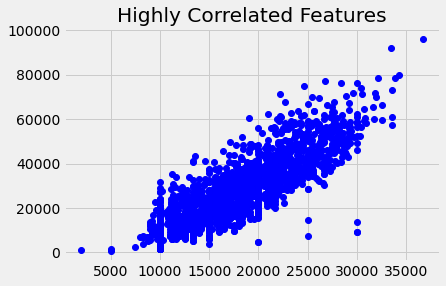

In [823]:
plt.plot(features_sample['Avgloanamount'], features_sample['Totalprofit'], 'bo')
plt.title('Highly Correlated Features');

In [824]:
# Upper triangle of correlations
upper = correlations.where(np.triu(np.ones(correlations.shape), k=1).astype(np.bool))
upper.head()

,Totalprofit,Avgprofit,Avgloanamount,Avgtermdays,Avgdaysleft,Earlypayment,loannumber,loanamount,termdays,good_bad_flag,new_profit,loanamountdeviation,profitdeviation,termdaysdeviation,Age_y
Variable,,,,,,,,,,,,,,,
Totalprofit,NaN,0.656252,0.918545,0.428243,0.183404,0.902447,0.939435,0.859603,0.525033,0.089024,0.531113,-0.706319,-0.240100,-0.315246,-0.014213
Avgprofit,NaN,NaN,0.612499,0.927718,0.215257,0.467600,0.461867,0.544195,0.601286,0.051034,0.551618,-0.425418,-0.057425,-0.052901,0.028072
Avgloanamount,NaN,NaN,NaN,0.332187,0.213481,0.860269,0.853561,0.889530,0.476376,0.104491,0.501083,-0.696206,-0.230532,-0.325750,-0.003509
Avgtermdays,NaN,NaN,NaN,NaN,0.188150,0.231985,0.223934,0.291613,0.529879,0.015887,0.408751,-0.225178,0.070003,0.081948,0.022467
Avgdaysleft,NaN,NaN,NaN,NaN,NaN,0.286770,0.119987,0.234726,0.196652,0.238330,0.169256,-0.219060,-0.072825,-0.098522,0.018240


In [825]:
# Select columns with correlations above threshold
to_drop = [column for column in upper.columns if any(upper[column] > threshold)]
print('There are %d columns to remove.' % (len(to_drop)))

There are 4 columns to remove.


In [826]:
to_drop

['Avgloanamount', 'Avgtermdays', 'Earlypayment', 'loannumber']

In [827]:
#columns to drop
features_sample = features_sample.drop(columns = to_drop)
print('data shape: ', features_sample.shape)

data shape:  (5818, 16)


### Feature Selection using Feature Importances

In [828]:
features_sample.tail(3)

,customerid,Totalprofit,Avgprofit,Avgdaysleft,loanamount,termdays,good_bad_flag,new_profit,loanamountdeviation,profitdeviation,termdaysdeviation,bank_account_type,employment_status_clients,level_of_education_clients,Age_x,Age_y
5815,8a858e9f59d692440159da2c60b42106,NaN,NaN,NaN,20000.0,30,-1,3000.0,NaN,NaN,NaN,Savings,Permanent,Graduate,MiddleAge,35
5816,8a858f0d58a18ebc0158a9bf124b5a30,NaN,NaN,NaN,10000.0,15,-1,1500.0,NaN,NaN,NaN,Savings,Permanent,Graduate,YoungAge,29
5817,8a85890253e2f1180153eae33e5e6bc3,NaN,NaN,NaN,20000.0,30,-1,4500.0,NaN,NaN,NaN,Savings,Permanent,Graduate,MiddleAge,32


In [829]:
feature_sample2 = features_sample.copy(deep=True)

In [830]:
feature_sample2.tail(3)

,customerid,Totalprofit,Avgprofit,Avgdaysleft,loanamount,termdays,good_bad_flag,new_profit,loanamountdeviation,profitdeviation,termdaysdeviation,bank_account_type,employment_status_clients,level_of_education_clients,Age_x,Age_y
5815,8a858e9f59d692440159da2c60b42106,NaN,NaN,NaN,20000.0,30,-1,3000.0,NaN,NaN,NaN,Savings,Permanent,Graduate,MiddleAge,35
5816,8a858f0d58a18ebc0158a9bf124b5a30,NaN,NaN,NaN,10000.0,15,-1,1500.0,NaN,NaN,NaN,Savings,Permanent,Graduate,YoungAge,29
5817,8a85890253e2f1180153eae33e5e6bc3,NaN,NaN,NaN,20000.0,30,-1,4500.0,NaN,NaN,NaN,Savings,Permanent,Graduate,MiddleAge,32


In [831]:
#Dummify the variables
feature_sample2 = pd.get_dummies(feature_sample2, columns=['bank_account_type', 'employment_status_clients','level_of_education_clients',
                                                           'Age_x'], drop_first=True, prefix=['bank_account_type', 
                                                                                              'employment_status_clients',
                                                                                              'level_of_education_clients','Age_x'])

In [832]:
feature_sample2.tail(3)

,customerid,Totalprofit,Avgprofit,Avgdaysleft,loanamount,termdays,good_bad_flag,new_profit,loanamountdeviation,profitdeviation,...,employment_status_clients_Permanent,employment_status_clients_Retired,employment_status_clients_Self-Employed,employment_status_clients_Student,employment_status_clients_Unemployed,level_of_education_clients_Post-Graduate,level_of_education_clients_Primary,level_of_education_clients_Secondary,Age_x_SeniorAge,Age_x_YoungAge
5815,8a858e9f59d692440159da2c60b42106,NaN,NaN,NaN,20000.0,30,-1,3000.0,NaN,NaN,...,1,0,0,0,0,0,0,0,0,0
5816,8a858f0d58a18ebc0158a9bf124b5a30,NaN,NaN,NaN,10000.0,15,-1,1500.0,NaN,NaN,...,1,0,0,0,0,0,0,0,0,1
5817,8a85890253e2f1180153eae33e5e6bc3,NaN,NaN,NaN,20000.0,30,-1,4500.0,NaN,NaN,...,1,0,0,0,0,0,0,0,0,0


In [833]:
train=feature_sample2[(feature_sample2['good_bad_flag'] == 1) | (feature_sample2['good_bad_flag'] == 0)]

In [834]:
test=feature_sample2[feature_sample2['good_bad_flag'] < 0]

In [835]:
print(train.shape)
print(test.shape)

(4368, 23)
(1450, 23)


In [836]:
display(train.head(3))
display(test.head(3))

,customerid,Totalprofit,Avgprofit,Avgdaysleft,loanamount,termdays,good_bad_flag,new_profit,loanamountdeviation,profitdeviation,...,employment_status_clients_Permanent,employment_status_clients_Retired,employment_status_clients_Self-Employed,employment_status_clients_Student,employment_status_clients_Unemployed,level_of_education_clients_Post-Graduate,level_of_education_clients_Primary,level_of_education_clients_Secondary,Age_x_SeniorAge,Age_x_YoungAge
0,8a1088a0484472eb01484669e3ce4e0b,1500.0,1500.000000,-7.00,10000.0,15,0,1500.0,0.000000,0.000000,...,1,0,0,0,0,0,1,0,0,1
1,8a1a1e7e4f707f8b014f797718316cad,19500.0,4875.000000,6.25,30000.0,60,1,9000.0,-12500.000000,-4125.000000,...,1,0,0,0,0,0,0,0,0,0
2,8a1a32fc49b632520149c3b8fdf85139,16500.0,2357.142857,1.00,20000.0,30,1,4500.0,-7142.857143,-2142.857143,...,1,0,0,0,0,0,0,0,0,0


,customerid,Totalprofit,Avgprofit,Avgdaysleft,loanamount,termdays,good_bad_flag,new_profit,loanamountdeviation,profitdeviation,...,employment_status_clients_Permanent,employment_status_clients_Retired,employment_status_clients_Self-Employed,employment_status_clients_Student,employment_status_clients_Unemployed,level_of_education_clients_Post-Graduate,level_of_education_clients_Primary,level_of_education_clients_Secondary,Age_x_SeniorAge,Age_x_YoungAge
6,8a28afc7474813a40147639ec637156b,32900.0,3290.0,6.000000,25000.0,30,-1,2500.0,-7200.000000,790.0,...,1,0,0,0,0,0,0,0,0,0
12,8a3735d5518aba7301518ac34413010d,18000.0,3000.0,13.333333,20000.0,30,-1,4500.0,-8333.333333,-1500.0,...,1,0,0,0,0,0,0,0,0,0
18,8a76e7d443e6e97c0143ed099d102b1d,3000.0,1500.0,1.500000,20000.0,30,-1,4500.0,-10000.000000,-3000.0,...,1,0,0,0,0,0,0,0,0,0


In [837]:
#rename good_bad
train.rename(columns={'good_bad_flag': 'TARGET'}, inplace=True)
test.rename(columns={'good_bad_flag': 'TARGET'}, inplace=True)

In [838]:
#drop traget column in test
test.drop('TARGET', axis=1, inplace=True)

In [839]:
print(train.shape)
print(test.shape)

(4368, 23)
(1450, 22)


In [840]:
train_labels = train['TARGET']
train_ids = train['customerid']
test_ids = test['customerid']

In [841]:
#remove the customerid
columns = ['customerid']
test.drop(columns, inplace=True, axis=1)
train.drop(columns, inplace=True, axis=1)

In [842]:
print('Training shape: ', train.shape)
print('Testing shape: ', test.shape)

Training shape:  (4368, 22)
Testing shape:  (1450, 21)


In [843]:
#We align the dataframes by the columns. This ensures we have the same columns in the training and testing datasets
#Match the columns in the dataframes
train, test = train.align(test, join = 'inner', axis = 1)
print('Training shape: ', train.shape)
print('Testing shape: ', test.shape)

Training shape:  (4368, 21)
Testing shape:  (1450, 21)


In [844]:
display(train.head(3))
display(test.head(3))

,Totalprofit,Avgprofit,Avgdaysleft,loanamount,termdays,new_profit,loanamountdeviation,profitdeviation,termdaysdeviation,Age_y,...,employment_status_clients_Permanent,employment_status_clients_Retired,employment_status_clients_Self-Employed,employment_status_clients_Student,employment_status_clients_Unemployed,level_of_education_clients_Post-Graduate,level_of_education_clients_Primary,level_of_education_clients_Secondary,Age_x_SeniorAge,Age_x_YoungAge
0,1500.0,1500.000000,-7.00,10000.0,15,1500.0,0.000000,0.000000,0.000000,31,...,1,0,0,0,0,0,1,0,0,1
1,19500.0,4875.000000,6.25,30000.0,60,9000.0,-12500.000000,-4125.000000,-22.500000,41,...,1,0,0,0,0,0,0,0,0,0
2,16500.0,2357.142857,1.00,20000.0,30,4500.0,-7142.857143,-2142.857143,-10.714286,41,...,1,0,0,0,0,0,0,0,0,0


,Totalprofit,Avgprofit,Avgdaysleft,loanamount,termdays,new_profit,loanamountdeviation,profitdeviation,termdaysdeviation,Age_y,...,employment_status_clients_Permanent,employment_status_clients_Retired,employment_status_clients_Self-Employed,employment_status_clients_Student,employment_status_clients_Unemployed,level_of_education_clients_Post-Graduate,level_of_education_clients_Primary,level_of_education_clients_Secondary,Age_x_SeniorAge,Age_x_YoungAge
6,32900.0,3290.0,6.000000,25000.0,30,2500.0,-7200.000000,790.0,1.5,35,...,1,0,0,0,0,0,0,0,0,0
12,18000.0,3000.0,13.333333,20000.0,30,4500.0,-8333.333333,-1500.0,-2.5,42,...,1,0,0,0,0,0,0,0,0,0
18,3000.0,1500.0,1.500000,20000.0,30,4500.0,-10000.000000,-3000.0,-15.0,39,...,1,0,0,0,0,0,0,0,0,0


In [845]:
# modeling 
import lightgbm as lgb

# utilities
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import LabelEncoder

In [846]:
# Initialize an empty array to hold feature importances
feature_importances = np.zeros(train.shape[1])

# Create the model with several hyperparameters
model = lgb.LGBMClassifier(objective='binary', boosting_type = 'goss', n_estimators = 10000, class_weight = 'balanced')

In [847]:
# Fit the model twice to avoid overfitting
for i in range(2):
    
    # Split into training and validation set
    train_features, valid_features, train_y, valid_y = train_test_split(train, train_labels, test_size = 0.3, random_state = i)
    
    # Train using early stopping
    model.fit(train_features, train_y, early_stopping_rounds=100, eval_set = [(valid_features, valid_y)], 
              eval_metric = 'auc', verbose = 200)
    
    # Record the feature importances
    feature_importances += model.feature_importances_

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[10]	valid_0's auc: 0.681567	valid_0's binary_logloss: 0.61905
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1]	valid_0's auc: 0.69315	valid_0's binary_logloss: 0.67697


In [848]:
# Make sure to average feature importances! 
x = feature_importances / 2
feature_importances = pd.DataFrame({'feature': list(train.columns), 
                                    'importance': feature_importances}).sort_values('importance', ascending = False)

feature_importances.head()

,feature,importance
2,Avgdaysleft,72.0
0,Totalprofit,62.0
9,Age_y,47.0
7,profitdeviation,30.0
11,employment_status_clients_Permanent,23.0


In [849]:
# Find the features with zero importance
zero_features = list(feature_importances[feature_importances['importance'] == 0.0]['feature'])
print('There are %d features with 0.0 importance' % len(zero_features))
feature_importances.tail()

There are 8 features with 0.0 importance


,feature,importance
15,employment_status_clients_Unemployed,0.0
16,level_of_education_clients_Post-Graduate,0.0
17,level_of_education_clients_Primary,0.0
19,Age_x_SeniorAge,0.0
20,Age_x_YoungAge,0.0


In [850]:
def plot_feature_importances(df, threshold = 0.9):
    
    plt.rcParams['font.size'] = 14
    
    # Sort features according to importance
    df = df.sort_values('importance', ascending = False).reset_index()
    
    # Normalize the feature importances to add up to one
    df['importance_normalized'] = df['importance'] / df['importance'].sum()
    df['cumulative_importance'] = np.cumsum(df['importance_normalized'])

    # Make a horizontal bar chart of feature importances
    plt.figure(figsize = (10, 6))
    ax = plt.subplot()
    
    # Need to reverse the index to plot most important on top
    ax.barh(list(reversed(list(df.index[:15]))), 
            df['importance_normalized'].head(15), 
            align = 'center', edgecolor = 'k')
    
    # Set the yticks and labels
    ax.set_yticks(list(reversed(list(df.index[:15]))))
    ax.set_yticklabels(df['feature'].head(15))
    
    # Plot labeling
    plt.xlabel('Normalized Importance'); plt.title('Feature Importances')
    plt.show()
    
    # Cumulative importance plot
    plt.figure(figsize = (10, 6))
    plt.plot(list(range(len(df))), df['cumulative_importance'], 'r-')
    plt.xlabel('Number of Features'); plt.ylabel('Cumulative Importance'); 
    
    plt.title('Cumulative Feature Importance');
    plt.show();
    
    importance_index = np.min(np.where(df['cumulative_importance'] > threshold))
    print('%d features required for %0.2f of cumulative importance' % (importance_index + 1, threshold))
    
    return df

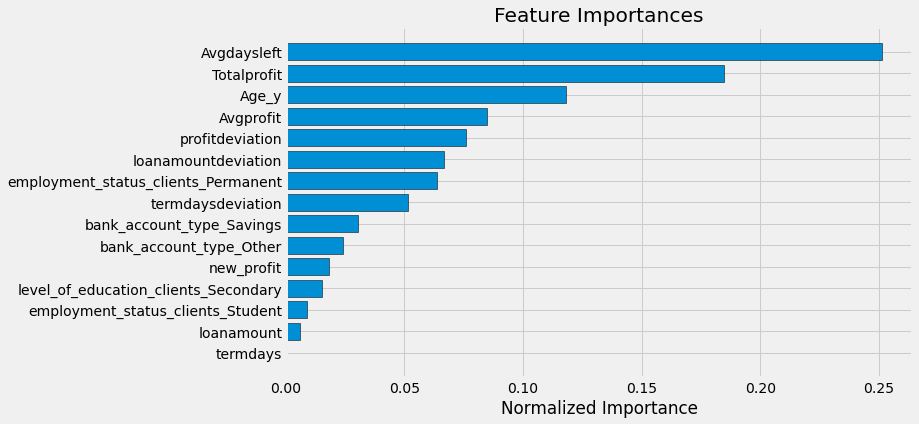

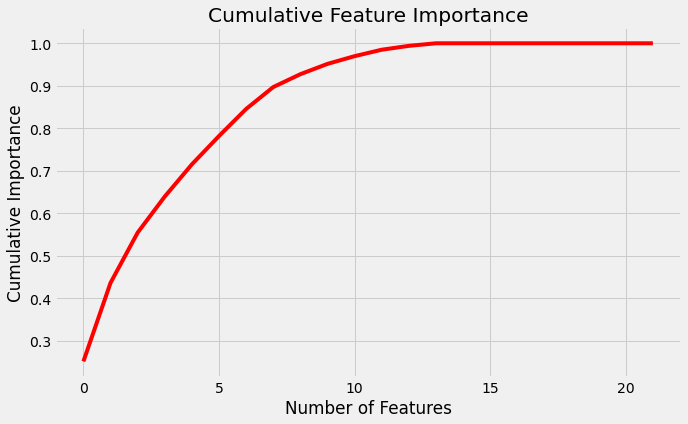

9 features required for 0.90 of cumulative importance


In [472]:
norm_feature_importances = plot_feature_importances(feature_importances)

In [851]:
train = train.drop(columns = zero_features)
test = test.drop(columns = zero_features)

print('Training shape: ', train.shape)
print('Testing shape: ', test.shape)

Training shape:  (4368, 13)
Testing shape:  (1450, 13)


In [852]:
def identify_zero_importance_features(train, train_labels, iterations = 2):

    # Initialize an empty array to hold feature importances
    feature_importances = np.zeros(train.shape[1])

    # Create the model with several hyperparameters
    model = lgb.LGBMClassifier(objective='binary', boosting_type = 'goss', n_estimators = 10000,class_weight = 'balanced')
    
    # Fit the model multiple times to avoid overfitting
    for i in range(iterations):
        
        # Split into training and validation set
        train_features, valid_features, train_y, valid_y = train_test_split(train, train_labels, test_size = 0.25, random_state = i)

        # Train using early stopping
        model.fit(train_features, train_y, early_stopping_rounds=100, eval_set = [(valid_features, valid_y)], 
                  eval_metric = 'auc', verbose = 200)

        # Record the feature importances
        feature_importances += model.feature_importances_ / iterations
    
    feature_importances = pd.DataFrame({'feature': list(train.columns), 'importance': feature_importances}).sort_values('importance', ascending = False)
    
    # Find the features with zero importance
    zero_features = list(feature_importances[feature_importances['importance'] == 0.0]['feature'])
    print('\nThere are %d features with 0.0 importance' % len(zero_features))
    
    return zero_features, feature_importances

In [853]:
second_round_zero_features, feature_importances = identify_zero_importance_features(train, train_labels)

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[10]	valid_0's auc: 0.665959	valid_0's binary_logloss: 0.626417
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[6]	valid_0's auc: 0.703987	valid_0's binary_logloss: 0.633627

There are 0 features with 0.0 importance


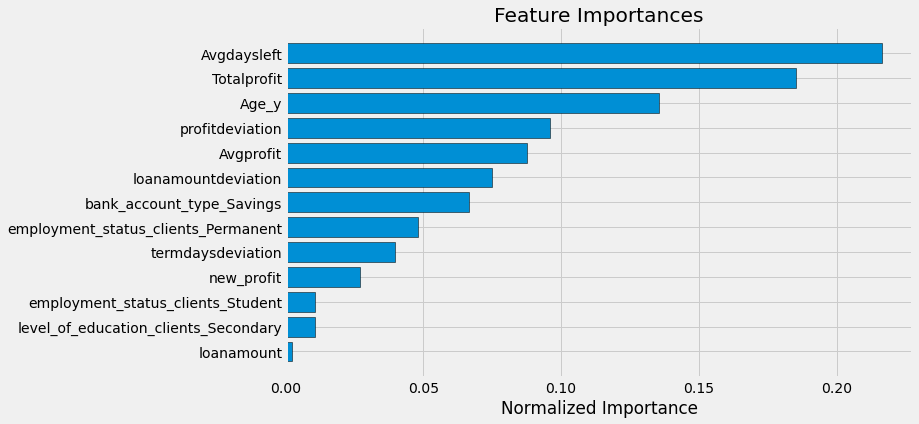

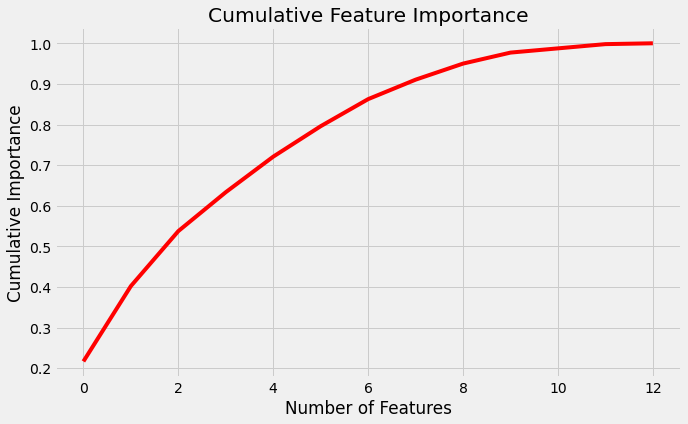

10 features required for 0.95 of cumulative importance


In [854]:
norm_feature_importances = plot_feature_importances(feature_importances, threshold = 0.95)

In [855]:
# Threshold for cumulative importance
threshold = 0.95

# Extract the features to keep
features_to_keep = list(norm_feature_importances[norm_feature_importances['cumulative_importance'] < threshold]['feature'])

# Create new datasets with smaller features
train_small = train[features_to_keep]
test_small = test[features_to_keep]

In [856]:
train_small['TARGET'] = train_labels
train_small['customerid'] = train_ids
test_small['customerid'] = test_ids

train_small.to_csv('m_train_small.csv', index = False)
test_small.to_csv('m_test_small.csv', index = False)

### 6. MODELLING

In [857]:
# Some sklearn tools for preprocessing and building a pipeline. 
# ColumnTransformer was introduced in 0.20 so make sure you have this version
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report

# Our algorithms, by from the easiest to the hardest to intepret.
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost.sklearn import XGBClassifier

In [858]:
features_sample.tail(3)

,customerid,Totalprofit,Avgprofit,Avgdaysleft,loanamount,termdays,good_bad_flag,new_profit,loanamountdeviation,profitdeviation,termdaysdeviation,bank_account_type,employment_status_clients,level_of_education_clients,Age_x,Age_y
5815,8a858e9f59d692440159da2c60b42106,NaN,NaN,NaN,20000.0,30,-1,3000.0,NaN,NaN,NaN,Savings,Permanent,Graduate,MiddleAge,35
5816,8a858f0d58a18ebc0158a9bf124b5a30,NaN,NaN,NaN,10000.0,15,-1,1500.0,NaN,NaN,NaN,Savings,Permanent,Graduate,YoungAge,29
5817,8a85890253e2f1180153eae33e5e6bc3,NaN,NaN,NaN,20000.0,30,-1,4500.0,NaN,NaN,NaN,Savings,Permanent,Graduate,MiddleAge,32


In [859]:
features_sample_final = features_sample.copy(deep=True)

In [860]:
#Dummify the variables
# Encoding categorical variables
# create three dummy variables using get_dummies, then exclude the first dummy column
def dummify(col_name, df):
    df_dummies = pd.get_dummies(df[col_name], prefix=col_name).iloc[:, 1:] 
    return df_dummies

In [861]:
#call the function
dummy_cols = ['bank_account_type','employment_status_clients','level_of_education_clients','Age_x']
for col_name in dummy_cols:
    dummies = dummify(col_name, features_sample_final)
    features_sample_final = pd.concat([features_sample_final, dummies], axis=1) # join the dummy columns to the original df
    features_sample_final = features_sample_final.drop([col_name], axis=1) # drop the original cat. vars column

In [862]:
features_sample_final.tail(3)

,customerid,Totalprofit,Avgprofit,Avgdaysleft,loanamount,termdays,good_bad_flag,new_profit,loanamountdeviation,profitdeviation,...,employment_status_clients_Permanent,employment_status_clients_Retired,employment_status_clients_Self-Employed,employment_status_clients_Student,employment_status_clients_Unemployed,level_of_education_clients_Post-Graduate,level_of_education_clients_Primary,level_of_education_clients_Secondary,Age_x_SeniorAge,Age_x_YoungAge
5815,8a858e9f59d692440159da2c60b42106,NaN,NaN,NaN,20000.0,30,-1,3000.0,NaN,NaN,...,1,0,0,0,0,0,0,0,0,0
5816,8a858f0d58a18ebc0158a9bf124b5a30,NaN,NaN,NaN,10000.0,15,-1,1500.0,NaN,NaN,...,1,0,0,0,0,0,0,0,0,1
5817,8a85890253e2f1180153eae33e5e6bc3,NaN,NaN,NaN,20000.0,30,-1,4500.0,NaN,NaN,...,1,0,0,0,0,0,0,0,0,0


In [863]:
#rename good_bad
features_sample_final.rename(columns={'good_bad_flag': 'TARGET'}, inplace=True)

In [864]:
features_sample_final.fillna(0, inplace=True)

In [865]:
features_sample_final.isnull().sum()

customerid                                  0
Totalprofit                                 0
Avgprofit                                   0
Avgdaysleft                                 0
loanamount                                  0
termdays                                    0
TARGET                                      0
new_profit                                  0
loanamountdeviation                         0
profitdeviation                             0
termdaysdeviation                           0
Age_y                                       0
bank_account_type_Savings                   0
employment_status_clients_Permanent         0
employment_status_clients_Retired           0
employment_status_clients_Self-Employed     0
employment_status_clients_Student           0
employment_status_clients_Unemployed        0
level_of_education_clients_Post-Graduate    0
level_of_education_clients_Primary          0
level_of_education_clients_Secondary        0
Age_x_SeniorAge                   

In [866]:
features_sample_final.tail(3)

,customerid,Totalprofit,Avgprofit,Avgdaysleft,loanamount,termdays,TARGET,new_profit,loanamountdeviation,profitdeviation,...,employment_status_clients_Permanent,employment_status_clients_Retired,employment_status_clients_Self-Employed,employment_status_clients_Student,employment_status_clients_Unemployed,level_of_education_clients_Post-Graduate,level_of_education_clients_Primary,level_of_education_clients_Secondary,Age_x_SeniorAge,Age_x_YoungAge
5815,8a858e9f59d692440159da2c60b42106,0.0,0.0,0.0,20000.0,30,-1,3000.0,0.0,0.0,...,1,0,0,0,0,0,0,0,0,0
5816,8a858f0d58a18ebc0158a9bf124b5a30,0.0,0.0,0.0,10000.0,15,-1,1500.0,0.0,0.0,...,1,0,0,0,0,0,0,0,0,1
5817,8a85890253e2f1180153eae33e5e6bc3,0.0,0.0,0.0,20000.0,30,-1,4500.0,0.0,0.0,...,1,0,0,0,0,0,0,0,0,0


In [867]:
train=features_sample_final[(features_sample_final['TARGET'] == 1) | (features_sample_final['TARGET'] == 0)]

In [868]:
test=features_sample_final[features_sample_final['TARGET'] < 0]

In [869]:
X = train.drop(["customerid", "TARGET"], axis=1)
print("Train Set Shape: {} Rows, {} Columns".format(*X.shape))
test = test.drop(["TARGET"], axis=1)
print("Submission Set Shape: {} Rows, {} Columns".format(*test.shape))
#y = train["TARGET"].values
y = train["TARGET"]

Train Set Shape: 4368 Rows, 21 Columns
Submission Set Shape: 1450 Rows, 22 Columns


In [870]:
X.head(3)

,Totalprofit,Avgprofit,Avgdaysleft,loanamount,termdays,new_profit,loanamountdeviation,profitdeviation,termdaysdeviation,Age_y,...,employment_status_clients_Permanent,employment_status_clients_Retired,employment_status_clients_Self-Employed,employment_status_clients_Student,employment_status_clients_Unemployed,level_of_education_clients_Post-Graduate,level_of_education_clients_Primary,level_of_education_clients_Secondary,Age_x_SeniorAge,Age_x_YoungAge
0,1500.0,1500.000000,-7.00,10000.0,15,1500.0,0.000000,0.000000,0.000000,31,...,1,0,0,0,0,0,1,0,0,1
1,19500.0,4875.000000,6.25,30000.0,60,9000.0,-12500.000000,-4125.000000,-22.500000,41,...,1,0,0,0,0,0,0,0,0,0
2,16500.0,2357.142857,1.00,20000.0,30,4500.0,-7142.857143,-2142.857143,-10.714286,41,...,1,0,0,0,0,0,0,0,0,0


In [871]:
y

0       0
1       1
2       1
3       1
4       1
       ..
5805    1
5806    1
5807    0
5808    1
5809    1
Name: TARGET, Length: 4368, dtype: int32

In [872]:
#split the train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=.3, random_state=42)

In [873]:
from sklearn.dummy import DummyClassifier

In [874]:
clf_dummy = DummyClassifier(strategy="most_frequent")
X_train, X_test, y_train, y_test = train_test_split(X, y)
clf_dummy.fit(X_train, y_train)
clf_dummy.score(X_test, y_test)

0.7857142857142857

In [875]:
from sklearn.metrics import confusion_matrix,accuracy_score,recall_score,roc_auc_score,classification_report,roc_auc_score,roc_curve,auc

#Model function
def model(algorithm,dtrain_X,dtrain_Y,dtest_X,dtest_Y,cols=None):

    algorithm.fit(dtrain_X[cols],dtrain_Y)
    predictions = algorithm.predict(dtest_X[cols])
    print (algorithm)
    
    print ("Accuracy score : ", accuracy_score(predictions,dtest_Y))
    print ("Recall score   : ", recall_score(predictions,dtest_Y))
    print ("classification report :\n",classification_report(predictions,dtest_Y))
    
    fig = plt.figure(figsize=(10,8))
    ax  = fig.add_subplot(111)
    prediction_probabilities = algorithm.predict_proba(dtest_X[cols])[:,1]
    fpr , tpr , thresholds   = roc_curve(dtest_Y,prediction_probabilities)
    ax.plot(fpr,tpr,label   = ["Area under curve : ",auc(fpr,tpr)],linewidth=2,linestyle="dotted")
    ax.plot([0,1],[0,1],linewidth=2,linestyle="dashed")
    plt.legend(loc="best")
    plt.title("ROC-CURVE & AREA UNDER CURVE")
    #ax.set_facecolor("k")

### Logistic Regression

LogisticRegression()
Accuracy score :  0.7893772893772893
Recall score   :  0.7945590994371482
classification report :
               precision    recall  f1-score   support

           0       0.06      0.58      0.12        26
           1       0.99      0.79      0.88      1066

    accuracy                           0.79      1092
   macro avg       0.53      0.69      0.50      1092
weighted avg       0.97      0.79      0.86      1092



C:\Users\dejag\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


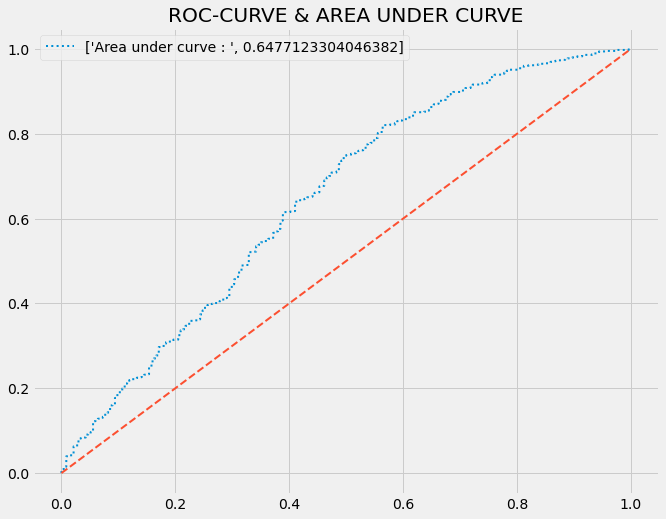

In [876]:
from sklearn.linear_model import LogisticRegression
logit = LogisticRegression()
model(logit,X_train,y_train,X_test,y_test,X_train.columns)

### Random Forest Classifier

RandomForestClassifier()
Accuracy score :  0.7445054945054945
Recall score   :  0.7993795243019648
classification report :
               precision    recall  f1-score   support

           0       0.17      0.32      0.22       125
           1       0.90      0.80      0.85       967

    accuracy                           0.74      1092
   macro avg       0.54      0.56      0.53      1092
weighted avg       0.82      0.74      0.78      1092



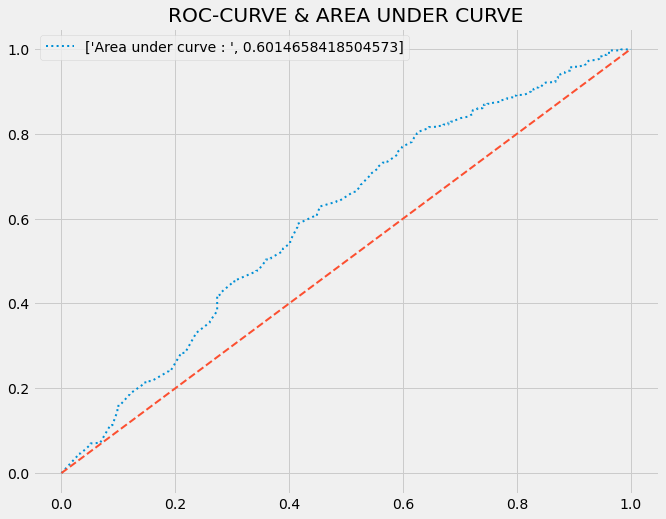

In [877]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier()
model(rfc,X_train,y_train,X_test,y_test,X_train.columns)

### Decision Tree Classifier

DecisionTreeClassifier()
Accuracy score :  0.6804029304029304
Recall score   :  0.8040621266427718
classification report :
               precision    recall  f1-score   support

           0       0.30      0.27      0.29       255
           1       0.78      0.80      0.79       837

    accuracy                           0.68      1092
   macro avg       0.54      0.54      0.54      1092
weighted avg       0.67      0.68      0.68      1092



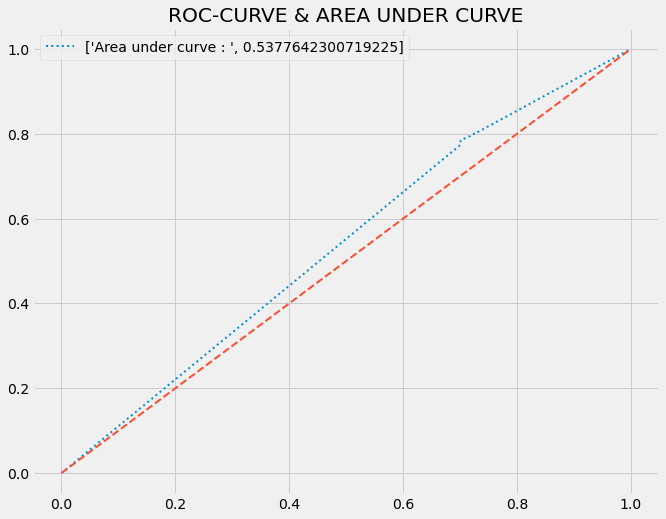

In [879]:
from sklearn.tree import DecisionTreeClassifier
dtc = DecisionTreeClassifier()
model(dtc,X_train,y_train,X_test,y_test,X_train.columns)

### Gaussian Naive Bayes

GaussianNB()
Accuracy score :  0.7701465201465202
Recall score   :  0.8178010471204189
classification report :
               precision    recall  f1-score   support

           0       0.26      0.44      0.32       137
           1       0.91      0.82      0.86       955

    accuracy                           0.77      1092
   macro avg       0.58      0.63      0.59      1092
weighted avg       0.83      0.77      0.79      1092



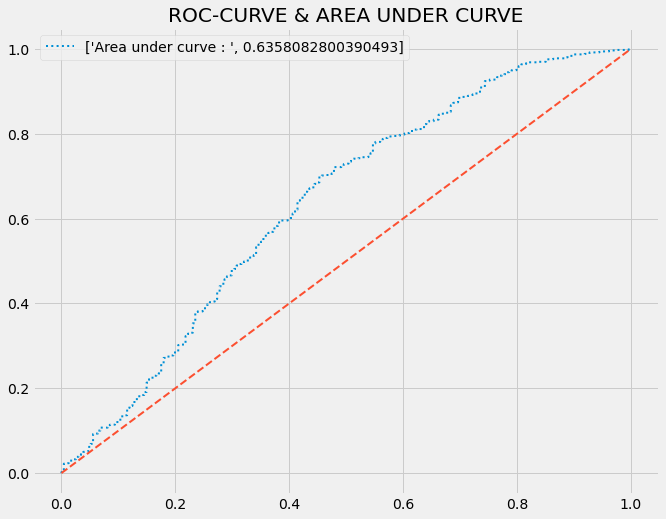

In [881]:
from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB()
model(gnb,X_train,y_train,X_test,y_test,X_train.columns)

### XGBoost Classifier

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)
Accuracy score :  0.7738095238095238
Recall score   :  0.8058058058058059
classification report :
               precision    recall  f1-score   support

           0       0.17      0.43      0.24        93
           1       0.94      0.81      0.87       999

    accuracy                           0.77      1092
   macro avg       0.55      0.62      0.56      1092
weighted avg       0.87      0.77      0.81    

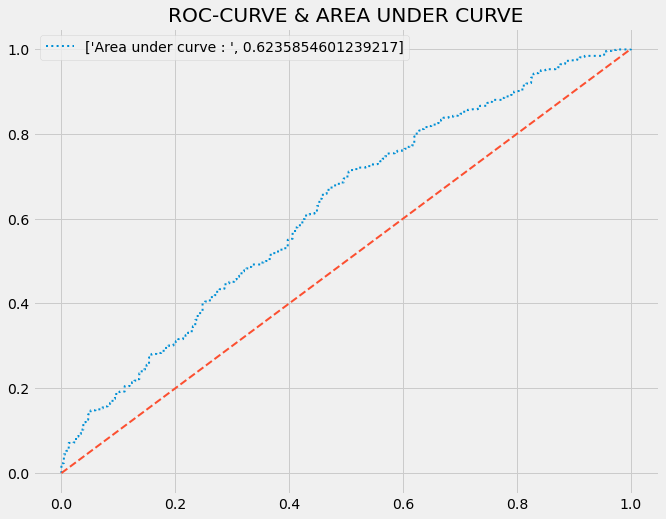

In [883]:
from xgboost import XGBClassifier
xgb = XGBClassifier()
model(xgb,X_train,y_train,X_test,y_test,X_train.columns)

### Gradient Boosting Classifier

GradientBoostingClassifier()
Accuracy score :  0.793040293040293
Recall score   :  0.8110236220472441
classification report :
               precision    recall  f1-score   support

           0       0.18      0.55      0.27        76
           1       0.96      0.81      0.88      1016

    accuracy                           0.79      1092
   macro avg       0.57      0.68      0.58      1092
weighted avg       0.91      0.79      0.84      1092



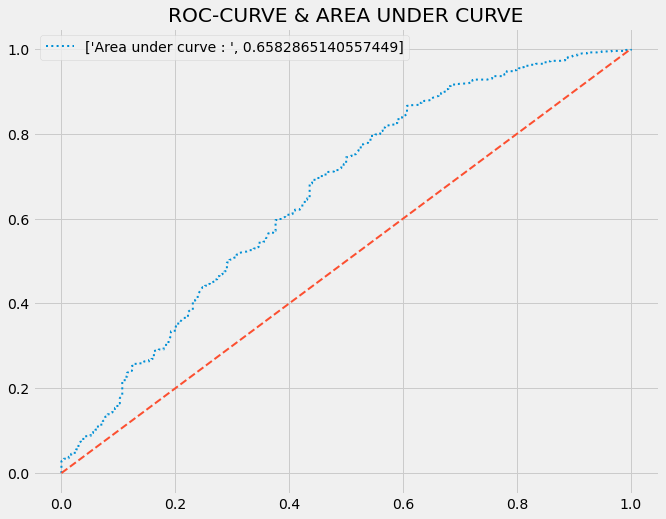

In [884]:
from sklearn.ensemble import GradientBoostingClassifier
gbc = GradientBoostingClassifier()
model(gbc,X_train,y_train,X_test,y_test,X_train.columns)

### Explaining the models

In [887]:
from yellowbrick.classifier import ConfusionMatrix, ClassificationReport

C:\Users\dejag\anaconda3\lib\site-packages\sklearn\base.py:209: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  warnings.warn('From version 0.24, get_params will raise an '


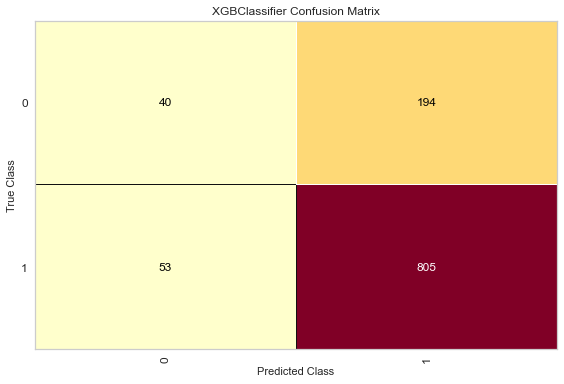

In [888]:
fig, ax = plt.subplots()
cm = ConfusionMatrix(xgb, classes=[0, 1], ax=ax)

#Fit fits the passed model. This is unnecessary if you pass the visualizer a pre-fitted model
cm.fit(X_train, y_train)

#To create the ConfusionMatrix, we need some test data. Score runs predict() on the data
#and then creates the confusion_matrix from scikit learn.
cm.score(X_test, y_test)

#How did we do?
cm.poof()

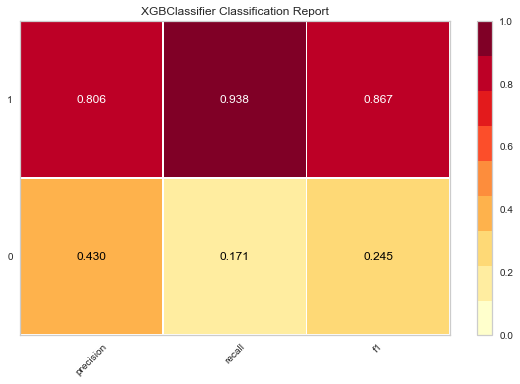

In [889]:
fig, ax = plt.subplots()
visualizer = ClassificationReport(xgb, classes=[0, 1], ax=ax)
ax.grid(False)

visualizer.fit(X_train, y_train)  # Fit the training data to the visualizer
visualizer.score(X_test, y_test)  # Evaluate the model on the test data
g = visualizer.poof()             # Draw/show/poof the data

### Submission File 

In [890]:
test_sub_X = test[[i for i in test.columns if i not in ['customerid']]]
gbc = GradientBoostingClassifier()
gbc.fit(X_train,y_train)
sub_prob = gbc.predict_proba(test_sub_X)[:,1]
sub_prob = pd.DataFrame(sub_prob)
ids = test[["customerid"]]
subm  = ids.merge(sub_prob,left_index=True,right_index=True,how="left")
sample_submission  = subm.rename(columns={"customerid":'customerid',0:'Good_Bad_flag'})

In [891]:
sample_submission.head()

,customerid,Good_Bad_flag
6,8a28afc7474813a40147639ec637156b,0.883586
12,8a3735d5518aba7301518ac34413010d,0.626785
18,8a76e7d443e6e97c0143ed099d102b1d,0.728507
21,8a818823525dceef01525deda2480384,0.943054
23,8a818926522ea5ef01523aff15c37482,0.891353


In [892]:
sample_submission.to_csv("best_model.csv",index = False)